In [2]:
import pygplates
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
import numpy as np

import paleogeography as pg

%matplotlib inline



basedir = '/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'

time = 396 #396
sampling = 2.0  # NB is sampling is less than 0.5, can run into rounding errors when trying to create GeometryOnSphere

rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % basedir,
                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % basedir])

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,time)


# load all the features from the different environment categories into a single collection of features
pg_features = pg.load_paleogeography(pg_dir)

# rasterise points using default environment list 
pg_points = pg.rasterise_paleogeography(pg_features,rotation_model,time,sampling=sampling)


['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/lm_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/sm_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']
[]
no features of type i


In [3]:
deep_ocean_features = []
for feature in pg_points:
    if feature.get_shapefile_attribute('Layer') is None:
        deep_ocean_features.append(feature)


In [4]:
MODELDIR = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/'
RotFile_List = ['%s/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot' % MODELDIR]
GPML_List = ['%s/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz' % MODELDIR,\
             '%s/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz' % MODELDIR,\
             '%s/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz' % MODELDIR]

#####################################
rotation_model = pygplates.RotationModel(RotFile_List)
topology_features = pygplates.FeatureCollection()
for file in GPML_List:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)
#'''

resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)



Generating distances for Plate 701 ...
Generating distances for Plate 430 ...
Generating distances for Plate 1001 ...
Generating distances for Plate 9012 ...
Generating distances for Plate 601 ...
Generating distances for Plate 9006 ...
Generating distances for Plate 602 ...
Generating distances for Plate 305 ...
Generating distances for Plate 9004 ...
Generating distances for Plate 9005 ...
Generating distances for Plate 902003 ...
Generating distances for Plate 101 ...
Generating distances for Plate 16111 ...
Generating distances for Plate 902 ...
Generating distances for Plate 926 ...
Generating distances for Plate 919 ...
Generating distances for Plate 401 ...


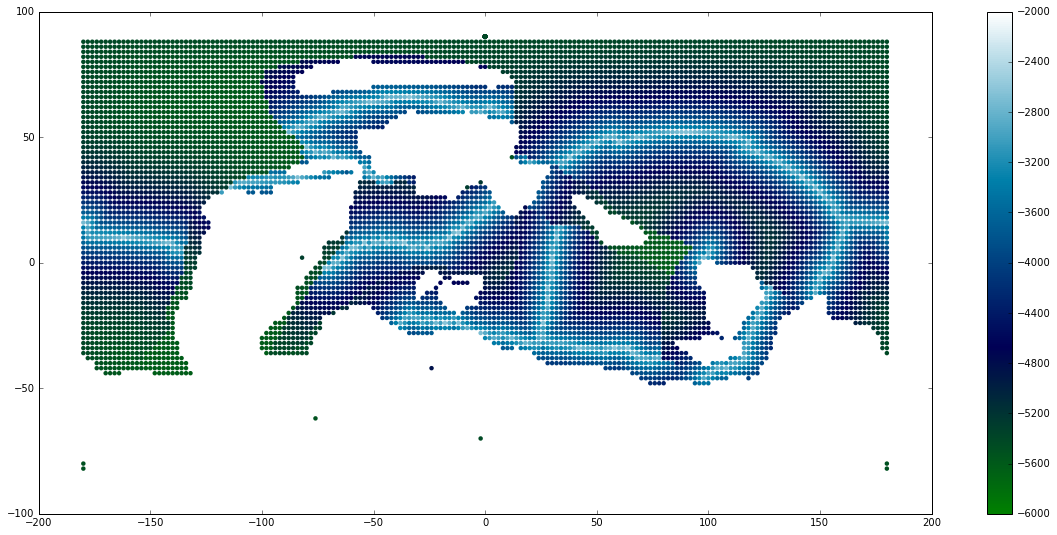

In [5]:
pX,pY,pZ = pg.find_distance_to_nearest_ridge(resolved_topologies,shared_boundary_sections,deep_ocean_features)

pAge = np.array(pZ) / 50.

pDepth = pg.age2depth(pAge)


plt.figure(figsize=(20,9))

#for ridge in mid_ocean_ridges_on_plate:
#    plt.plot(ridge.to_lat_lon_array()[:,1],ridge.to_lat_lon_array()[:,0])

plt.scatter(pX,pY,c=pDepth,edgecolors='',vmin=-6000,vmax=-2000,cmap=plt.cm.ocean)

plt.colorbar()         
plt.show()


In [6]:
# save the point features to a gpml file
point_features = []

for point in zip(pX,pY,pAge):
    
    point_feature = pygplates.Feature()
    point_feature.set_geometry(pygplates.PointOnSphere(point[1],point[0]))
    
    # note that we add 'time' to the age at the time of computation
    # to get the valid time in Ma
    point_feature.set_valid_time(point[2]+time,-1)  
    point_features.append(point_feature)

pygplates.FeatureCollection(point_features).write('age_from_distance_to_mor.gpmlz')    
